In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn

from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

import torchvision.models as models

from torch.optim import lr_scheduler

import torch.optim as optim

import os

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224), 0),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224),0),
        transforms.ToTensor(),
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=0, pin_memory=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 2685
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.NEAREST)
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [6]:
import torchvision

/opt/conda/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


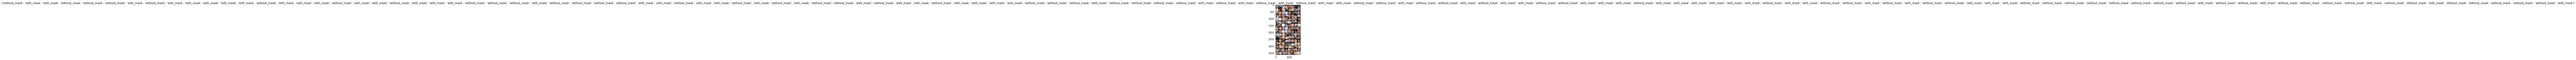

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
import copy, time

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_accuracy.append(epoch_acc)
            else:
                test_loss.append(epoch_loss)
                test_accuracy.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_accuracy, test_loss, test_accuracy

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
model = models.mobilenet_v2(pretrained=True, progress=True)
for param in model.parameters():
    param.requires_grad = False

# model

num_ftrs = model.classifier[1].in_features

model.classifier[1] = nn.Sequential(
                        nn.Linear(num_ftrs, 2),
                        nn.Softmax(-1)
                    )


model = model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
model, train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6893 Acc: 0.5449
val Loss: 0.6485 Acc: 0.7178

Epoch 1/24
----------
train Loss: 0.6331 Acc: 0.7408
val Loss: 0.6133 Acc: 0.8362

Epoch 2/24
----------
train Loss: 0.5880 Acc: 0.8324
val Loss: 0.5867 Acc: 0.8676

Epoch 3/24
----------
train Loss: 0.5563 Acc: 0.8790
val Loss: 0.5591 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.5280 Acc: 0.9073
val Loss: 0.5403 Acc: 0.9268

Epoch 5/24
----------
train Loss: 0.5095 Acc: 0.9177
val Loss: 0.5237 Acc: 0.9434

Epoch 6/24
----------
train Loss: 0.4925 Acc: 0.9240
val Loss: 0.5097 Acc: 0.9434

Epoch 7/24
----------
train Loss: 0.4798 Acc: 0.9382
val Loss: 0.5097 Acc: 0.9416

Epoch 8/24
----------
train Loss: 0.4809 Acc: 0.9367
val Loss: 0.5090 Acc: 0.9451

Epoch 9/24
----------
train Loss: 0.4792 Acc: 0.9430
val Loss: 0.5056 Acc: 0.9460

Epoch 10/24
----------
train Loss: 0.4786 Acc: 0.9330
val Loss: 0.5059 Acc: 0.9416

Epoch 11/24
----------
train Loss: 0.4778 Acc: 0.9326
val Loss: 0.5038 Acc: 0.9434

Ep

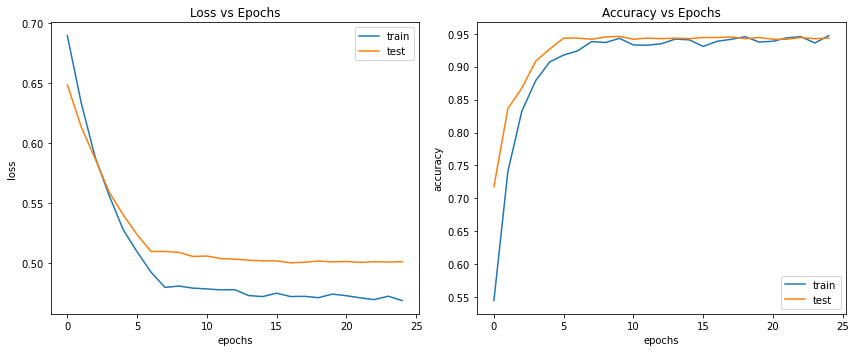

In [18]:
fig, (plt1, plt2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(12)

fig.set_tight_layout(True)

plt1.plot(train_loss,label='train')
plt1.plot(test_loss,label='test')

plt2.plot(train_accuracy,label='train')
plt2.plot(test_accuracy,label='test')

plt1.set_title('Loss vs Epochs')
plt1.set_xlabel('epochs')
plt1.set_ylabel('loss')

plt2.set_title('Accuracy vs Epochs')
plt2.set_xlabel('epochs')
plt2.set_ylabel('accuracy')

plt1.legend()
plt2.legend()

plt.show()

In [19]:
fig.savefig('MobileNet_plots.png')

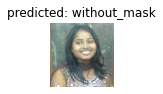

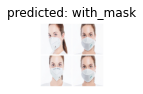

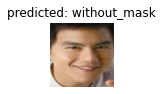

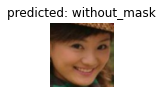

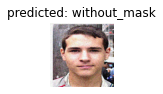

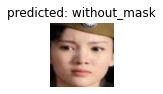

In [20]:
import matplotlib.pyplot as plt

visualize_model(model)

plt.ioff()
plt.show()

In [21]:
PATH = 'trained_mobilenet.pth'
torch.save(model.state_dict(), PATH)

In [19]:
model1 = models.mobilenet_v2(pretrained=True, progress=True)
num_ftrs = model1.classifier[1].in_features
model1.classifier[1] = nn.Sequential(
                        nn.Linear(num_ftrs, 2),
                        nn.Softmax(-1)
                    )

model1.load_state_dict(torch.load(PATH))
model1.eval()

model1.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/jovyan/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


URLError: <urlopen error [Errno 99] Cannot assign requested address>

In [ ]:
visualize_model(model1)

plt.ioff()
plt.show()